In [23]:
import random

import pandas as pd
import matplotlib.pyplot as plt


In [15]:
train_df = pd.read_csv("../data/raw/gtsrb-german-traffic-sign/Train.csv")
test_df = pd.read_csv("../data/raw/gtsrb-german-traffic-sign/Test.csv")

In [16]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [17]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [18]:
# Filter the columns out
train_df = train_df[["Path", "ClassId"]]
test_df = test_df[["Path", "ClassId"]]

In [19]:
# Check for missing values
train_df.isna().sum()

Path       0
ClassId    0
dtype: int64

In [20]:
# Addthe full path to the images
train_df["Path"] = "gtsrb-german-traffic-sign/" + train_df["Path"]
test_df["Path"] = "gtsrb-german-traffic-sign/" + test_df["Path"]

In [21]:
train_df.head(2)

,Path,ClassId
0,gtsrb-german-traffic-sign/Train/20/00020_00000...,20
1,gtsrb-german-traffic-sign/Train/20/00020_00000...,20


image shape : (38, 41, 3)
Image label: 1


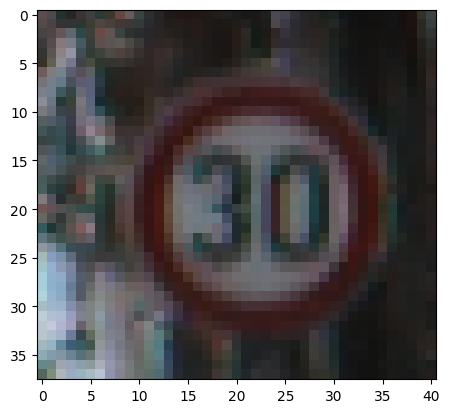

In [38]:
# Visualization
random_img_path = random.choice(train_df["Path"])
img_path = "../data/raw/" + random_img_path

img = plt.imread(img_path)
print(f'image shape : {img.shape}')
print(f'Image label: {train_df[train_df["Path"] == random_img_path]["ClassId"].values[0]}')
plt.imshow(plt.imread(img_path))